In [1]:
# INIT

import ipaddress
import json
import pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdict
from datetime import datetime, timedelta
import numpy as np
from pathlib import Path
from collections import Counter
import ast
import matplotlib.colors as mcolors
import maxminddb
from itertools import combinations
from constants import servers
import networkx as nx
import logging

def ip_to_subnet(ip):
    return str(ipaddress.IPv4Network(f"{ip}/24", strict=False).network_address) + "/24"

def ip_to_asn(ip_address, db_path='data/external/GeoLite2-ASN.mmdb'):
    try:
        with maxminddb.open_database(db_path) as reader:
            result = reader.get(ip_address)
            return result['autonomous_system_organization']
    except Exception as e:
        return None
   
def set_plt_latex_format():
    plt.rcParams.update({
        "font.size": 10,          # Base font size
        "axes.titlesize": 10,     # Title size
        "axes.labelsize": 8,     # Axis label size
        "xtick.labelsize": 8,    # X-tick label size
        "ytick.labelsize": 8,    # Y-tick label size
        "legend.fontsize": 8,    # Legend font size
        "figure.titlesize": 10,    # Figure title size
        "text.usetex": True,
        "font.family": "serif",
        "font.serif": ["Computer Modern Roman"]
    })

def retrieve_color_palette(n_colors=10, blends=None):
    if blends is None or len(blends) < 2:
        blends = ['#c40d1e', '#9013fe']  # Default red to purple
    
    # Convert all hex colors to RGB
    rgb_colors = [np.array(mcolors.hex2color(color)) for color in blends]
    
    # Calculate how many segments we need
    segments = len(blends) - 1
    colors_per_segment = n_colors // segments
    extra_colors = n_colors % segments  # Distribute remainder colors among segments
    
    # Create the color list
    colors = []
    
    for i in range(segments):
        start_color = rgb_colors[i]
        end_color = rgb_colors[i+1]
        
        # Calculate how many colors for this segment (distribute remainder)
        segment_colors = colors_per_segment + (1 if i < extra_colors else 0)
        
        # Create colors for this segment
        for j in range(segment_colors):
            if segment_colors > 1:  # Avoid division by zero
                t = j / (segment_colors - 1)
            else:
                t = 0
            color = tuple(start_color + (end_color - start_color) * t)
            colors.append(color)
    
    # Create matplotlib colormap and seaborn palette
    custom_cmap = mcolors.ListedColormap(colors)
    #custom_palette = sns.color_palette(colors, n_colors=len(colors))
    
    return colors, custom_cmap#, custom_palette

In [ ]:
logging.basicConfig(level=logging.INFO)

default_port = "18080"

# in complete script do: for node in servers.keys()
node = 'sfo'
ban = 'with'

folder_path = Path(f"data/packets/{node}")
my_ip = servers[node]

peer_packets_df = pd.read_parquet(f'data/dataframes/peer_packets_{node}_{ban}.parquet')
peers_df = pd.read_parquet(f"data/dataframes/peers_{node}_{ban}.parquet")

In [3]:
# Generic all fields that appear in the dataset: 
print(peers_df.keys())
print(peer_packets_df.keys())

Index(['ip', 'port', 'type', 'id', 'source_ip', 'timestamp', 'pl_identifier',
       'pruning_seed', 'rpc_port', 'rpc_credits_per_hash', 'last_seen',
       'cumulative_difficulty', 'cumulative_difficulty_top64',
       'current_height', 'top_id', 'top_version',
       '������iN������������`��-�c\v:&�W\t��y�������=����_H��4z��4��� ������\f\bm_ip[�s0m_port\a�Gtype\bid"���\f�\v\fadr\f\baddr\f\bm_ip�>��m_port\a�Ftype\bid8}\n��1��\brpc_port\a�F\fadr\f\baddr\f\bm_ip���m_port'],
      dtype='object')
Index(['frame_number', 'source_ip', 'source_port', 'dst_ip', 'dst_port',
       'timestamp', 'command', 'monero_flags', 'tcp_segments', 'tcp_length',
       'cumulative_difficulty', 'cumulative_difficulty_top64',
       'current_height', 'top_id', 'top_version', 'pruning_seed',
       'peerlist_length', 'local_time', 'my_port', 'network_id', 'peer_id',
       'support_flags', 'rpc_port', 'status', 'rpc_credits_per_hash', 'block',
       'current_blockchain_height',

In [4]:
# BASIC SUMMARY
anomaly_dict = {}
num_unique_ips = peer_packets_df['source_ip'].nunique() # number of unique IPs I have opened a connection to
total_unique_ips = pd.concat([
    peer_packets_df['source_ip'], 
    peers_df['ip']
]).nunique()
num_unique_neighbors = total_unique_ips - num_unique_ips # number of unique neighbors extracted from all peer lists
num_tot_packets = len(peer_packets_df)
num_peer_lists = peers_df[peers_df['source_ip'] != my_ip]['pl_identifier'].nunique()
all_unique_ips = pd.DataFrame({
    'ip': pd.concat([peer_packets_df['source_ip'], peers_df['ip']]).unique()
})

print(f"For node {node}: \n    {num_tot_packets} packets, \n    connected to {num_unique_neighbors} unique IPs, \n    collected {num_unique_ips} from {num_peer_lists}.")
print(f"totals: {len(all_unique_ips)} unique IPs")

totalPackets = num_tot_packets # LATEX
totalUniqueIPs = num_unique_ips # LATEX
totalUniqueIPsPlusPL = num_unique_neighbors # LATEX
totalPeerLists = num_peer_lists # LATEX

For node ams: 
    4807042 packets, 
    connected to 11087 unique IPs, 
    collected 6697 from 171956.
totals: 17784 unique IPs


In [5]:
# EVIDENT CONNECTION LEVEL ANOMALIES
# support_flags
try: 
    support_flags_sources = peer_packets_df[(peer_packets_df['command'] == '1001') & (peer_packets_df['support_flags'].isna())]['source_ip'].unique().tolist()
    anomaly_dict['support_falgs'] = support_flags_sources
    logging.info(f"Violation - nunique support_flags IPs: {len(support_flags_sources)}")
except KeyError as e:
    logging.info(f"No Violation - No support_falgs violation in dataset")

# last_seen timestamp
try:
    lastseen_sources = peers_df[peers_df['last_seen'].notna()]['source_ip'].unique().tolist() 
    anomaly_dict['last_seen'] = lastseen_sources
    logging.info(f"Violation - nunique last_seen IPs: {len(lastseen_sources)}")
except KeyError as e:
    logging.info(f"No Violation - No last_seen violation in dataset")

INFO:root:Violation - nunique support_flags IPs: 725
INFO:root:Violation - nunique last_seen IPs: 62


410846
3010
266 with less than 0.5 subnets:
    promoted peers in a maximum of 124 subnets
    median: 6.0, mean: 29.5
send by 0 unique IPs

set()


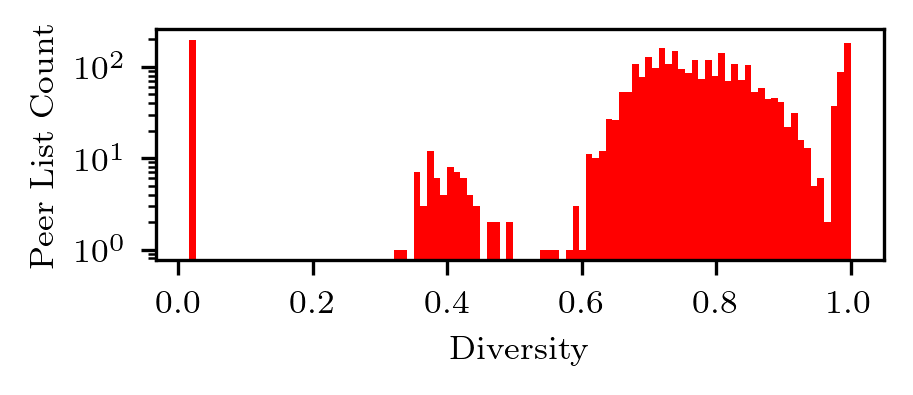

In [6]:
# PEER LIST DIVERSITY
peers_df['subnet'] = peers_df['ip'].apply(lambda ip: str(ipaddress.IPv4Network(f"{ip}/24", strict=False).network_address) + "/24")

def calc_diversity(ip_list, subnet_list):
    if len(ip_list) < 250:
        return None
    
    unique_subnets = len(set(subnet_list))
    total_ips = len(ip_list)
    
    raw_diversity = unique_subnets / total_ips
    
    return raw_diversity

pl_by_source = peers_df.groupby('pl_identifier').agg({
    'ip': lambda x: x.tolist(),
    'subnet': lambda x: x.tolist(),
    'source_ip': 'first',
}).reset_index()

pl_by_source.columns = ['source_pl', 'peer_ips', 'peer_subnets', 'source_ip']

pl_by_source['pl_diversity_normalized'] = pl_by_source.apply(
    lambda row: calc_diversity(row['peer_ips'], row['peer_subnets']), axis=1
)

print(len(pl_by_source))

pl_by_source = pl_by_source.dropna(subset=['pl_diversity_normalized'])

print(len(pl_by_source))

pl_by_source['actual_subnets'] = pl_by_source['peer_subnets'].apply(lambda x: len(set(x)))

if False:
    threshold = 10 # pl_by_source['pl_diversity_normalized'].quantile(0.05)
    low_diversity = pl_by_source[pl_by_source['actual_subnets'] < threshold]
else:
    threshold = 0.5 # pl_by_source['pl_diversity_normalized'].quantile(0.05)
    low_diversity = pl_by_source[pl_by_source['pl_diversity_normalized'] < threshold]

print(f"{len(low_diversity)} with less than {threshold} subnets:")
print(f"    promoted peers in a maximum of {low_diversity['actual_subnets'].max()} subnets")
print(f"    median: {low_diversity['actual_subnets'].median()}, mean: {low_diversity['actual_subnets'].mean():.1f}")

print(f"send by {pl_by_source[pl_by_source['actual_subnets'] < threshold]['source_ip'].nunique()} unique IPs\n")
totalUniqueIPsPLDiv = pl_by_source[pl_by_source['actual_subnets'] < threshold]['source_ip'].nunique() # LATEX
anomaly_dict['PL_div'] = pl_by_source[pl_by_source['actual_subnets'] < threshold]['source_ip'].unique()

tmp_asns = set()
for tmp_ip in pl_by_source[pl_by_source['actual_subnets'] < threshold]['source_ip'].unique():
    tmp_asns.add(ip_to_asn(tmp_ip))
print(tmp_asns)

UniqueASNsPLDiv = len(tmp_asns)   # LATEX

set_plt_latex_format()
plt.figure(figsize=(3.13,1), dpi=300)
plt.xlabel('Diversity')
plt.ylabel('Peer List Count')
plt.hist(pl_by_source['pl_diversity_normalized'], bins=100, log=True, color="red")
#plt.axvline(0.1, color='gray', linestyle='--')
plt.savefig('results/graphs/loc_pl_diversity.pdf',
           bbox_inches='tight',
           pad_inches=0.1,
           dpi=300)
plt.show()

0.19104285037558377
186 with less than 0.2 subnets:
    promoted peers in a maximum of 2795 subnets
    median: 6.0, mean: 250.6
send by 0 unique IPs

set()


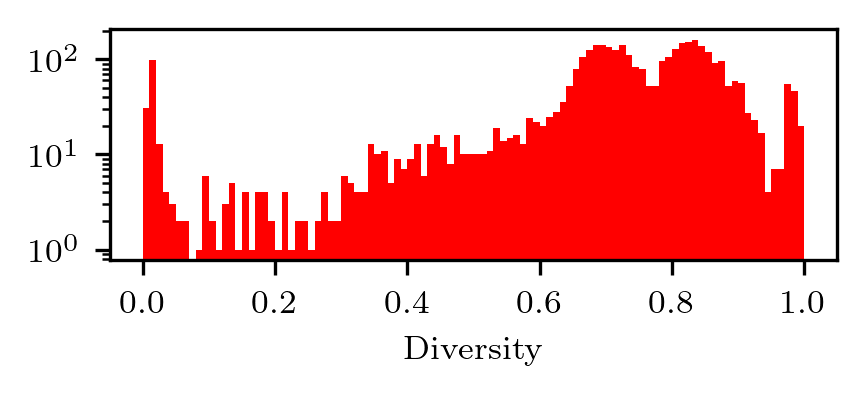

In [7]:
## by IP, usually gets the same resulting unique IPs, local PL is better 
pl_by_source_ip = peers_df.groupby('source_ip').agg({
    'ip': lambda x: x.tolist(),
    'subnet': lambda x: x.tolist(),
}).reset_index()

pl_by_source_ip.columns = ['source_ip', 'peer_ips', 'peer_subnets']

pl_by_source_ip['pl_diversity_normalized'] = pl_by_source_ip.apply(
    lambda row: calc_diversity(row['peer_ips'], row['peer_subnets']), axis=1
)

pl_by_source_ip = pl_by_source_ip.dropna(subset=['pl_diversity_normalized'])

pl_by_source_ip['actual_subnets'] = pl_by_source_ip['peer_subnets'].apply(lambda x: len(set(x)))

if False:
    threshold = 10 # pl_by_source_ip['pl_diversity_normalized'].quantile(0.05)
    low_diversity = pl_by_source_ip[v['actual_subnets'] < threshold]
else:
    threshold = 0.2 # pl_by_source_ip['pl_diversity_normalized'].quantile(0.05)
    low_diversity = pl_by_source_ip[pl_by_source_ip['pl_diversity_normalized'] < threshold]

print(pl_by_source_ip['pl_diversity_normalized'].quantile(0.05))

print(f"{len(low_diversity)} with less than {threshold} subnets:")
print(f"    promoted peers in a maximum of {low_diversity['actual_subnets'].max()} subnets")
print(f"    median: {low_diversity['actual_subnets'].median()}, mean: {low_diversity['actual_subnets'].mean():.1f}")

print(f"send by {pl_by_source_ip[pl_by_source_ip['actual_subnets'] < threshold]['source_ip'].nunique()} unique IPs\n")

tmp_asns = set()
for tmp_ip in pl_by_source_ip[pl_by_source_ip['actual_subnets'] < threshold]['source_ip'].unique():
    tmp_asns.add(ip_to_asn(tmp_ip))
print(tmp_asns)

set_plt_latex_format()
plt.figure(figsize=(3.13,1), dpi=300)
plt.xlabel('Diversity')
plt.hist(pl_by_source_ip['pl_diversity_normalized'], log=True, bins=100, color='red')
plt.show()

In [8]:
# CONNECTION ANOMALIES: Ping, TS Latency,  

def get_connection_info(row, my_ip, default_port):
    # Determine if outgoing (my_ip uses ephemeral port) or incoming (peer uses ephemeral port)
    if row['source_ip'] == my_ip and row['source_port'] != default_port:
        # Outgoing: my port is ephemeral
        return 'outgoing', row['dst_ip'], f"{my_ip}:{row['source_port']}->{row['dst_ip']}:{row['dst_port']}"
    elif row['source_ip'] != my_ip and row['dst_port'] != default_port:
        # Outgoing: peer is responding, but connection was initiated by me
        return 'outgoing', row['source_ip'], f"{my_ip}:{row['dst_port']}->{row['source_ip']}:{row['source_port']}"
    elif row['source_ip'] == my_ip and row['source_port'] == default_port:
        # Incoming: my port is default
        return 'incoming', row['dst_ip'], f"{my_ip}:{default_port}<-{row['dst_ip']}:{row['dst_port']}"
    elif row['source_ip'] != my_ip and row['dst_port'] == default_port:
        # Incoming: I'm responding, but connection was initiated by peer
        return 'incoming', row['source_ip'], f"{my_ip}:{default_port}<-{row['source_ip']}:{row['source_port']}"
    
def group_per_connection(peer_packets_df, my_ip, default_port):
    all_data = peer_packets_df.copy()
    connection_info = all_data.apply(get_connection_info, axis=1, args=(my_ip, default_port))
    all_data['direction'] = [info[0] for info in connection_info]
    all_data['peer_ip'] = [info[1] for info in connection_info]
    all_data['connection_key'] = [info[2] for info in connection_info]
    
    # Sort by connection and timestamp
    all_data = all_data.sort_values(['connection_key', 'timestamp'])
    all_data['connection_key_cat'] = all_data['connection_key'].astype('category')
    all_data['prev_connection'] = all_data['connection_key_cat'].shift(1)
    all_data['time_diff'] = all_data['timestamp'].diff().dt.total_seconds()
    
    # Identify connection breaks
    all_data['is_break'] = (
        (all_data['connection_key_cat'] != all_data['prev_connection']) |
        (all_data['time_diff'] > 120) |
        (all_data['time_diff'].isna())
    )
    all_data['connection_id'] = all_data['is_break'].cumsum()
    grouped = all_data.groupby('connection_id')
    
    # initial conn_df with basic info
    valid_conn_ids = grouped.size()[grouped.size() >= 1].index
    conn_info = []
    
    for conn_id in valid_conn_ids:
        conn = grouped.get_group(conn_id)
        source_ips = np.array(conn['source_ip'])
        if len(source_ips) == 1 and source_ips[0] == my_ip:
            continue

        source_ip = conn['source_ip'].iloc[0]
        timestamps = np.array(conn['timestamp'])
        duration = timestamps[-1] - timestamps[0]

        commands = np.array(conn['command'])
        monero_flags = np.array(conn['monero_flags'])
        timestamps = np.array(conn['timestamp'])
        

        my_ip_mask = (source_ips == my_ip)
        peer_ip_mask = (source_ips != my_ip)
        req_mask = (monero_flags == '1')
        resp_mask = (monero_flags == '2')
        ts_mask = (commands == '1002')

        # check for tcp anomalies
        my_ts_resp_mask = (my_ip_mask & resp_mask & ts_mask)
        peer_ts_req_mask = (peer_ip_mask & req_mask & ts_mask)
        peer_diff = len(commands[my_ts_resp_mask]) - len(commands[peer_ts_req_mask])
        peer_ts_resp_mask = (peer_ip_mask & resp_mask & ts_mask)
        my_ts_req_mask = (my_ip_mask & req_mask & ts_mask)
        my_diff = len(commands[peer_ts_resp_mask]) - len(commands[my_ts_req_mask])
        tcp_anomaly = False
        if peer_diff > 2 or my_diff < -2:
            tcp_anomaly = True

        # calculate timed sync latency
        ts_series = pd.Series(timestamps[peer_ts_req_mask])
        latency = None
        if not tcp_anomaly and len(ts_series) > 5:
            differences = ts_series.diff().dt.total_seconds().dropna()
            latency = min(differences.median(), differences.mean())

        # check for Ping flooding
        ping_mask = (commands == '1003')
        peer_ping_mask = (peer_ip_mask & ping_mask)
        ping_series = pd.Series(timestamps[peer_ping_mask])
        ping_frequency = None
        if len(ping_series) > 2:
            differences = ping_series.diff().dt.total_seconds().dropna()
            ping_frequency = max(differences.median(), differences.mean())

        # check for completed handshake
        handshake_mask = (commands == '1001')
        my_handshakes = (handshake_mask & my_ip_mask)
        peer_handshakes = (handshake_mask & peer_ip_mask)
        incomplete_hs = False
        if (len(commands[my_handshakes]) == 0) or (len(commands[peer_handshakes]) == 0):
            incomplete_hs = True

        # average peer list length per connection
        pl_sizes = np.array(conn['peerlist_length'])
        if np.isnan(pl_sizes).all():
            avg_pl_size = None
            total_pl_size = None
            total_pls = None
        else:
            avg_pl_size = np.nanmean(pl_sizes)
            total_pl_size = np.nansum(pl_sizes)
            total_pls = np.sum(~np.isnan(conn['peerlist_length']))

        conn_info.append({
            'connection_id': conn_id,
            'source_ip': source_ip, 
            'tcp_anomaly': tcp_anomaly,
            'initial_command': commands[0],
            'peer_ip': conn['peer_ip'].iloc[0],
            'direction': conn['direction'].iloc[0],
            'duration': duration / pd.Timedelta(seconds=1),
            'total_commands': len(commands),
            'peer_commands': len(commands[peer_ip_mask]),
            'ts_latency': latency,
            'total_pings': len(commands[peer_ping_mask]),
            'incomplete_hs': incomplete_hs,
            'ping_frequency': ping_frequency,
            'req_res_diff': peer_diff,                      # my responses minus the peer's requests -> might be higher if wireshark dissector does not catch all requests by the peer
            'res_req_diff': my_diff,                        # peer's responses minus my requests -> might be higher if wireshark dissector does not catch all responses 
            'avg_pl_length': avg_pl_size,
            'total_pl_size': total_pl_size,
            'total_pls': total_pls,
            'time_connection_initiation': timestamps[0]
        })

    conn_df = pd.DataFrame(conn_info)
    return grouped, conn_df

grouped, conn_df = group_per_connection(peer_packets_df, my_ip, default_port)



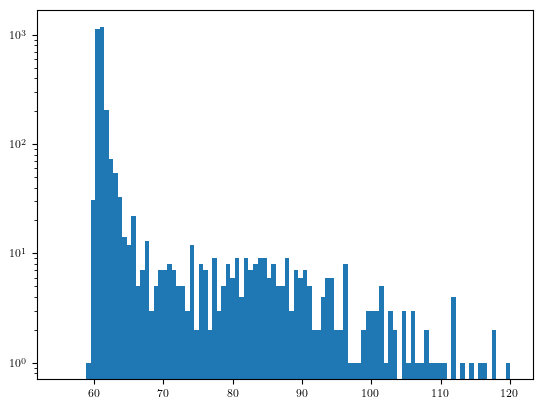

In [9]:
plt.hist(conn_df['ts_latency'], range=(55, 120), bins=100, log=True)
plt.show()

In [10]:
# BEHAVIORAL CONNECTION LEVEL ANOMALIES continues...
conditions = [
    ((conn_df['tcp_anomaly'])),
    ((conn_df['incomplete_hs'])),
    (conn_df['duration'] < 1),
    (conn_df['duration'] < 10),
    (conn_df['duration'] < 30),
    ((conn_df['total_pings'] > 2)),                                         # ping_flooding
    (conn_df['ts_latency'] > 75), #conn_df['ts_latency'].quantile(0.95)),         # throttled_ts
    ((conn_df['ts_latency'] < conn_df['ts_latency'].quantile(0.6)) & (conn_df['duration'] > conn_df[conn_df['duration'] > 10]['duration'].quantile(0.5))) # average connection duration
]

choices = [
    'incomplete_tcp',
    'incomplete_hs',
    'short_lived_1',
    'short_lived_10',
    'short_lived_30',
    'ping_flooding',
    'throttled_ts',
    'standard_average'
]

conn_df['category'] = np.select(conditions, choices, default='standard_other')

anomalous_categories = ['short_lived_1', 'ping_flooding', 'throttled_ts']

#print(conn_df['category'].value_counts())

for c in anomalous_categories:
    try: 
        num_connections_of_cat = conn_df['category'].value_counts()[c]
        unique_ips_in_cat = conn_df[conn_df['category'] == c]['source_ip'].unique()

        if c == 'short_lived_1':
            peer_ip_counts = conn_df[conn_df['category'].isin([c])]['peer_ip'].value_counts()
            filtered_counts = peer_ip_counts[peer_ip_counts > 2]
            anomaly_dict[f"{c}_two"] = filtered_counts.keys()
            logging.info(f"Violation - {c}_two anomalies found for unique IPs: {len(anomaly_dict[f"{c}_two"])}")

            filtered_counts = peer_ip_counts[peer_ip_counts > 10]
            anomaly_dict[f"{c}_ten"] = filtered_counts.keys()
            logging.info(f"Violation - {c}_ten anomalies found for unique IPs: {len(anomaly_dict[f"{c}_ten"])}")
        else:
            anomaly_dict[c] = unique_ips_in_cat
            logging.info(f"Violation - {c} anomalies found for unique IPs: {len(anomaly_dict[c])}")
    except KeyError:
        logging.info(f"No Violation - No {c} violation in data set.")




INFO:root:Violation - short_lived_1_two anomalies found for unique IPs: 78
INFO:root:Violation - short_lived_1_ten anomalies found for unique IPs: 11
INFO:root:Violation - ping_flooding anomalies found for unique IPs: 502
INFO:root:Violation - throttled_ts anomalies found for unique IPs: 174


In [11]:
conn_df[conn_df['category'] == 'short_lived_1']['source_ip'].value_counts()

source_ip
162.218.65.219    19517
164.92.217.0        948
192.210.201.39       32
146.70.119.59        19
66.23.198.161        19
                  ...  
101.100.173.23        1
100.7.21.116          1
100.42.187.156        1
100.35.37.203         1
100.14.73.50          1
Name: count, Length: 2724, dtype: int64

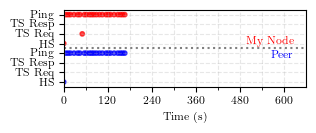

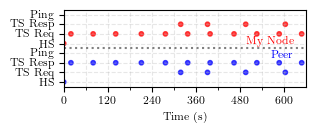

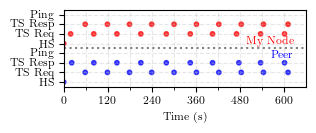

In [12]:
# RANDOM PLOTS
def get_command_category(cmd, flag, source, my_ip):
    """Map commands and flags to categories"""
    if source == my_ip:
        i = 4
    else:
        i = 0
        
    category_map = {
        ('1001', '1'): 1+i,    # Handshake Request
        ('1001', '2'): 1+i,    # HS Resp
        ('1002', '1'): 2+i,    # Timed Sync Request
        ('1002', '2'): 3+i,    # TS Response
        ('1003', '1'): 4+i,    # Ping
        ('1003', '2'): 4+i     # Pong
    }
    
    return category_map.get((cmd, flag), 0)

def setup_axis_appearance(ax, time_duration_seconds, show_ylabel=True):
    """Configure axis appearance for LaTeX paper"""
    category_labels = ['HS', 'TS Req', 'TS Resp', 'Ping', 'HS', 'TS Req', 'TS Resp', 'Ping']

    ax.set_xlabel('Time (s)', fontsize=8)
    #ax.set_ylabel('Command Type', fontsize=10)
    ax.set_xticks(range(0, time_duration_seconds + 1, 120))
    ax.set_yticks([1, 2, 3, 4, 5, 6, 7, 8])
    ax.set_yticklabels(category_labels, fontsize=8)
    ax.tick_params(axis='both', which='major', labelsize=8)
    ax.set_ylim(0.5, 8.5)
    
    ax.set_xlim(0, time_duration_seconds)
    ax.grid(True, alpha=0.3, linestyle='--')
    
    # Add minor grid lines at 60s intervals
    ax.set_xticks(range(0, time_duration_seconds, 60), minor=True)
    ax.grid(True, alpha=0.3, linestyle='--', which='minor')

def plot_command_timeline_subplot(ax, base_commands, base_flags, base_series, base_sources, title, 
                                time_duration_seconds=300, show_ylabel=True):
    """Plot command timeline on given axis"""
    if len(base_series) == 0:
        ax.text(0.5, 0.5, 'No data', transform=ax.transAxes, 
                ha='center', va='center', fontsize=7)
        ax.set_title(title, fontsize=8, pad=8)

        setup_axis_appearance(ax, time_duration_seconds, show_ylabel)
        return
    
    # Convert to seconds from start and filter by duration
    time_seconds = (base_series - base_series.iloc[0]).dt.total_seconds()
    time_mask = time_seconds <= time_duration_seconds
    
    if not time_mask.any():
        ax.text(0.5, 0.5, 'No data in time range', transform=ax.transAxes, 
                ha='center', va='center', fontsize=9)
        ax.set_title(title, fontsize=10, pad=10)
        setup_axis_appearance(ax, time_duration_seconds, show_ylabel)
        return
    
    # Filter data and create categories    
    commands_filtered = base_commands[time_mask]
    flags_filtered = base_flags[time_mask]
    time_filtered = time_seconds[time_mask]
    sources_filtered = base_sources[time_mask]
    
    categories = [get_command_category(cmd, flag, source, my_ip) 
                  for cmd, flag, source in zip(commands_filtered, flags_filtered, sources_filtered)]
    
    #print(f"{title}: {sources_filtered[:2]} : {base_series[:1]}")
    
    colors = ['red' if source == my_ip else 'blue' 
          for source in sources_filtered]

    ax.scatter(time_filtered, categories, c=colors, s=10, alpha=0.7)

    ax.axhline(4.5, color='gray', linestyle=':')

    ax.text(time_duration_seconds * 0.95, 4.7, 'My Node', 
            ha='right', va='bottom', fontsize=8, color='red')
    
    # Add text below the line  
    ax.text(time_duration_seconds * 0.95, 4.3, 'Peer', 
            ha='right', va='top', fontsize=8, color='blue')
    
    #ax.set_title(title, fontsize=10, pad=10, weight='bold')
    if sources_filtered[0] == my_ip:
        direction = 'outgoing'
    else: 
        direction = 'incoming'
    setup_axis_appearance(ax, time_duration_seconds, show_ylabel)
    
# categories to plot
import random

set_plt_latex_format()
categories_to_plot = ['ping_flooding', 'throttled_ts', 'standard_average']  # Modify this array as needed
max_connections_per_type = 1
time_duration_seconds=660

# Add randomness to peer selection
connection_data = {}
used_peers = set()

for category in categories_to_plot:
        
    category_df = conn_df[conn_df['category'] == category]
    
    # Randomly shuffle the connections in this category
    category_df = category_df.sample(frac=1, random_state=random.randint(1, 10000))
    
    connection_data[category] = []
    count = 0
    
    for idx, row in category_df.iterrows():
        if count >= max_connections_per_type:
            break
            
        conn_id = row['connection_id']
        peer_ip = row['peer_ip']

        if peer_ip in used_peers:
            continue
            
        conn = grouped.get_group(conn_id)
        
        commands = np.array(conn['command'])
        monero_flags = np.array(conn['monero_flags'])
        timestamps = np.array(conn['timestamp'])
        source_ips = np.array(conn['source_ip'])
            
        used_peers.add(peer_ip)
        
        # base commands only interesting as only these are expectable
        base_mask = np.isin(commands, ['1001', '1002', '1003'])
        base_series = pd.Series(timestamps[base_mask])
        
        connection_data[category].append({
            'peer': peer_ip,
            'source_ips': source_ips[base_mask],
            'commands': commands[base_mask],
            'flags': monero_flags[base_mask],
            'series': base_series
        })
        count += 1

# individual plots for each category
for category in connection_data:
    for j, data in enumerate(connection_data[category]):
        fig, ax = plt.subplots(figsize=(3.13, 1))
        
        title = f"{category}_{j+1}\n{data['peer']}-{data['series'].iloc[0]}"
        
        plot_command_timeline_subplot(
            ax, data['commands'], data['flags'], 
            data['series'], data['source_ips'], title, 
            time_duration_seconds, show_ylabel=True
        )
        
        #plt.tight_layout()
        plt.savefig(f'results/graphs/{category}_{j+1}.pdf', bbox_inches='tight', dpi=300)
        plt.show()
        #plt.close()

In [13]:
# PEER LIST SIMILARITY
def analyze_local_pl_similarity(peers_df):
    pl_by_source = peers_df.groupby('pl_identifier').agg({
        'ip': lambda x: x.tolist(),
        'subnet': lambda x: x.tolist(),
        'source_ip': 'first',
        }).reset_index()
    
    pl_by_source.columns = ['source_pl', 'peer_ips', 'peer_subnets', 'source_ip']
    #print(unique_peers_by_source.head())

    pl_by_source['peer_count'] = pl_by_source['peer_ips'].apply(len)
    pl_by_source = pl_by_source[pl_by_source['peer_count'] > 249]

    pl_sets = {row['source_pl']: set(row['peer_ips']) for _, row in pl_by_source.iterrows()}
    
    pl_subnet_sets = {row['source_pl']: set(row['peer_subnets']) for _, row in pl_by_source.iterrows()}

    source_ip_lookup = pl_by_source.set_index('source_pl')['source_ip'].to_dict()

    overlaps = []
    for source1, source2 in combinations(pl_sets.keys(), 2):
        ip_1 = source_ip_lookup[source1]
        ip_2 = source_ip_lookup[source2]

        if ip_1 == ip_2:
            continue
       
        ip_intersection = len(pl_sets[source1] & pl_sets[source2])
        ip_union = len(pl_sets[source1] | pl_sets[source2])
        ip_jaccard = ip_intersection / ip_union if ip_union > 0 else 0

        sub_intersection = len(pl_subnet_sets[source1] & pl_subnet_sets[source2])
        sub_union = len(pl_subnet_sets[source1] | pl_subnet_sets[source2])
        sub_jaccard = sub_intersection / sub_union if sub_union > 0 else 0
    
        overlaps.append({
            'source1': source1, 
            'source2': source2,
            'source1_ip': ip_1,
            'source2_ip': ip_2,
            'ip_intersection': ip_intersection, 
            'ip_jaccard': ip_jaccard,
            'ip_union': ip_union,
            'sub_intersection': sub_intersection, 
            'sub_union': sub_union,
            'sub_jaccard': sub_jaccard
        })
    
    overlap_df = pd.DataFrame(overlaps)

    #overlap_df.to_csv(f'results/node_results/{node}_pl_df.csv', index=False)
    #pl_by_source['avg_pl_diversity'] = pl_by_source['peer_ips'].apply(calc_diversity)
    #mean_pl_div = pl_by_source.groupby('source_ip')['avg_pl_diversity'].mean()

    return overlap_df

local_overlap_df = analyze_local_pl_similarity(peers_df)

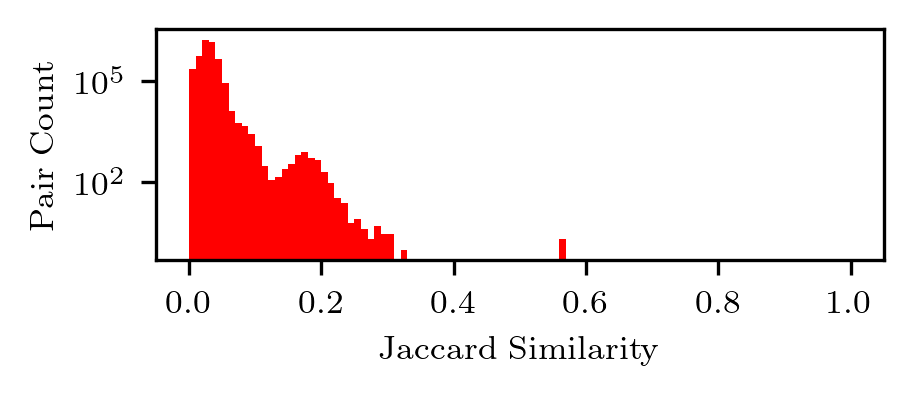

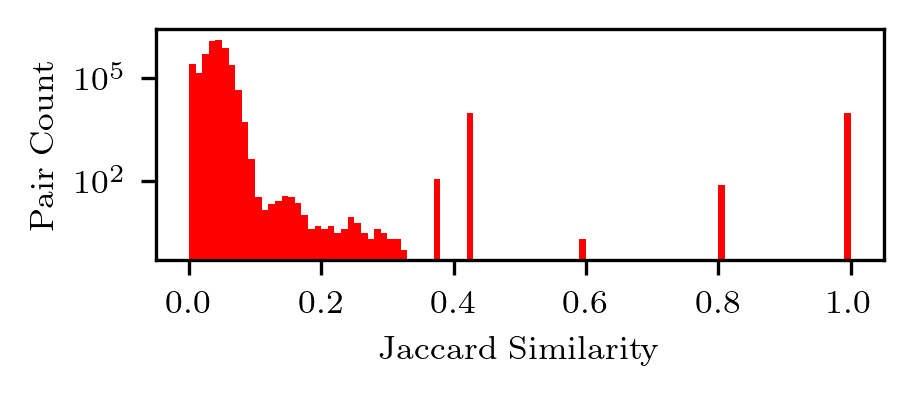

['199.116.84.24' '162.218.65.204' '209.222.252.14' '162.218.65.59'
 '23.92.36.56' '162.218.65.219' '91.198.115.56' '162.218.65.42'
 '91.198.115.71' '209.222.252.2' '91.198.115.246' '209.222.252.29'
 '162.218.65.136' '23.92.36.59' '209.222.252.71' '209.222.252.7'
 '199.116.84.8' '209.222.252.122' '91.198.115.238' '193.142.4.147'
 '162.218.65.112' '209.222.252.149' '209.222.252.167' '91.198.115.99'
 '199.116.84.221' '193.142.4.102' '91.198.115.118' '91.198.115.241'
 '162.218.65.67' '193.142.4.209' '91.198.115.26' '209.222.252.228'
 '91.198.115.190' '54.151.207.221' '209.222.252.32' '36.34.248.116'
 '100.42.27.71' '162.218.65.146' '91.198.115.25' '209.222.252.225'
 '209.222.252.162' '199.116.84.89' '193.142.4.107' '91.198.115.111'
 '199.116.84.43' '100.42.27.73' '209.222.252.46' '199.116.84.232'
 '162.218.65.172' '199.116.84.99' '91.198.115.207' '199.116.84.114'
 '193.142.4.79' '91.198.115.47' '162.218.65.98' '209.222.252.219'
 '193.142.4.108' '162.218.65.147' '209.222.252.199' '162.218.6

In [14]:
set_plt_latex_format()

plt.figure(figsize=(3.13,1), dpi=300)
plt.xlabel('Jaccard Similarity')
plt.ylabel('Pair Count')
plt.hist(local_overlap_df['ip_jaccard'], bins=100, range=(0,1), log=True, color='red')
plt.savefig('results/graphs/ip_similarity.pdf',
           bbox_inches='tight',
           pad_inches=0.1,
           dpi=300)
plt.show()

plt.figure(figsize=(3.13,1), dpi=300)
plt.ylabel('Pair Count')
plt.xlabel('Jaccard Similarity')
plt.hist(local_overlap_df['sub_jaccard'], bins=100, range=(0,1), log=True, color='red')
plt.savefig('results/graphs/sub_similarity.pdf',
           bbox_inches='tight',
           pad_inches=0.1,
           dpi=300)
plt.show()

high_overlap = local_overlap_df[local_overlap_df['sub_jaccard']>0.3]

print(high_overlap['source1_ip'].unique())
print(high_overlap['source2_ip'].unique())



anomaly_dict['pl_sim'] = np.concatenate([
    high_overlap['source1_ip'].unique(),
    high_overlap['source2_ip'].unique()
])

In [15]:
# PEER LIST SIMILARITY global, probably gonna stick to local one, similar to diversity, streamlined and best result
def analyze_global_pl_similarity(peers_df):
    '''Analyzes the global peer list of a peer where each peer list is aggregated and reduced to a unique set of peers.'''
    
    pl_by_source = peers_df.groupby('source_ip').agg({
        'ip': lambda x: x.tolist(),
        'subnet': lambda x: x.tolist()
        }).reset_index()
    
    pl_by_source.columns = ['source_ip', 'peer_ips', 'peer_subnets']
    
    pl_by_source['peer_count'] = pl_by_source['peer_ips'].apply(len)
    pl_by_source = pl_by_source[pl_by_source['peer_count'] > 240]
    
    peer_sets = {row['source_ip']: set(row['peer_ips'])
                for _, row in pl_by_source.iterrows()}
    
    subnet_sets = {row['source_ip']: set(row['peer_subnets']) 
                for _, row in pl_by_source.iterrows()}

    # pairwise overlaps
    overlaps = []
    for source1, source2 in combinations(peer_sets.keys(), 2):
        # IPs
        intersection = len(peer_sets[source1] & peer_sets[source2])
        union = len(peer_sets[source1] | peer_sets[source2])
        ip_jaccard = intersection / union if union > 0 else 0

        source1_subset_of_source2 = peer_sets[source1].issubset(peer_sets[source2])
        source2_subset_of_source1 = peer_sets[source2].issubset(peer_sets[source1])

        # Subnets
        intersection = len(subnet_sets[source1] & subnet_sets[source2])
        union = len(subnet_sets[source1] | subnet_sets[source2])
        sub_jaccard = intersection / union if union > 0 else 0
    
        overlaps.append({
            'source1': source1, 'source2': source2,
            'intersection': intersection, 'ip_jaccard': ip_jaccard,
            'union': union,
            'source1_subset_of_source2': source1_subset_of_source2,
            'source2_subset_of_source1': source2_subset_of_source1,
            'sub_jaccard': sub_jaccard
        })
    
    overlap_df = pd.DataFrame(overlaps)

    #max_sim_by_ip = overlap_df.groupby('source1')['jaccard_similarity'].max()
    #result_df['max_pl_sim'] = result_df['source_ip'].map(max_sim_by_ip)

    return overlap_df

#global_overlap_df = analyze_global_pl_similarity(peers_df)

In [16]:
#plt.hist(global_overlap_df['ip_jaccard'], bins=100, log=True)
#plt.show()
#plt.hist(global_overlap_df['sub_jaccard'], bins=100, log=True)
#plt.show()


#similarity_values = sorted(global_overlap_df['ip_jaccard'])
#gaps = np.diff(similarity_values)
#max_gap_idx = np.argmax(gaps)
#
#gap_start = similarity_values[max_gap_idx]
#gap_end = similarity_values[max_gap_idx + 1]
#threshold = (gap_start + gap_end) / 2
#print(threshold)
#
#global_overlap_df[global_overlap_df['ip_jaccard'] > threshold]

3244481
16381
Mean: 0.0120917992262843, median: 0.00018315018315018315


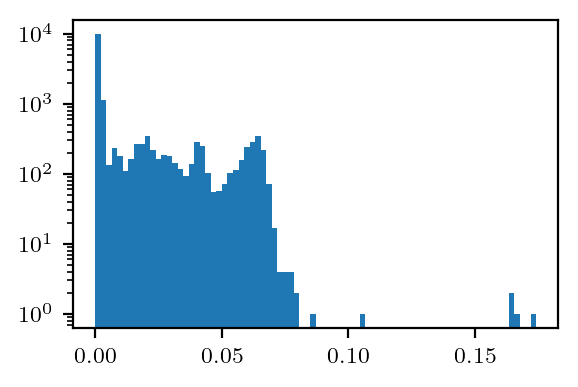

0.00018315018315018315
Threshold: 0.134, gap start: 0.10500610500610501 - end: 0.16391941391941392
['5.161.47.56', '66.85.146.138', '164.92.217.0', '185.218.124.120']
1488833
4188
Number of communities: 5
Community sizes: [1339, 983, 673, 649, 544]
Community 1: 1339 nodes - ['88.25.66.240', '24.16.191.210', '70.32.194.57', '209.38.198.43', '191.179.227.133', '44.201.235.189', '185.100.87.130', '109.206.219.6', '198.54.132.102', '74.76.14.31']
429
Lionlink present
Community 2: 983 nodes - ['185.246.84.179', '91.201.252.54', '71.212.130.236', '31.210.34.170', '168.119.134.54', '71.231.123.126', '37.59.20.42', '83.144.167.148', '91.209.70.35', '23.145.248.60']
384
Community 3: 673 nodes - ['100.34.9.122', '192.42.116.178', '185.177.248.19', '213.170.110.145', '23.88.124.70', '91.235.234.4', '209.38.115.217', '15.204.46.158', '5.75.166.225', '78.23.148.51']
285
Community 4: 649 nodes - ['37.120.211.92', '84.80.51.201', '159.69.36.66', '177.45.178.80', '185.156.175.51', '5.45.72.24', '103.2

In [32]:
# Network Analysis
edges = []

ext_peers_df = peers_df[peers_df['source_ip'] != my_ip]
edges = list(zip(ext_peers_df['source_ip'], ext_peers_df['ip']))

G = nx.from_edgelist(edges, create_using=nx.DiGraph())

print(len(G.edges()))
print(len(G.nodes()))

centrality = nx.in_degree_centrality(G)
centrality_values = sorted(list(centrality.values()))
print(f"Mean: {np.array(centrality_values).mean()}, median: {np.array(centrality_values)[int(len(centrality_values)/2)]}")
plt.figure(figsize=(3.13,2), dpi=200)
plt.hist(centrality_values, bins=80, log=True)
plt.show()

print(centrality_values[int(len(centrality_values)/2)])

gaps = np.diff(centrality_values)
max_gap_idx = np.argmax(gaps)

gap_start = centrality_values[max_gap_idx]
gap_end = centrality_values[max_gap_idx + 1]
threshold = (gap_start + gap_end) / 2


print(f"Threshold: {threshold:.3f}, gap start: {gap_start} - end: {gap_end}")
high_centrality_nodes = [node for node, cent in nx.in_degree_centrality(G).items() 
                        if cent > threshold]
print(high_centrality_nodes)

zero_out_degree_nodes = [node for node in G.nodes() if G.out_degree(node) == 0]
G.remove_nodes_from(zero_out_degree_nodes)
print(len(G.edges()))
print(len(G.nodes()))
import networkx.algorithms.community as nx_comm
communities = list(nx_comm.louvain_communities(G))
sizes = [len(c) for c in communities]
print(f"Number of communities: {len(communities)}")
print(f"Community sizes: {sorted(sizes, reverse=True)}")

for i, community in enumerate(sorted(communities, key=len, reverse=True)[:5]):
    print(f"Community {i+1}: {len(community)} nodes - {list(community)[:10]}")
    tmp_asns = set()
    for tmp_ip in list(community):
        tmp_asns.add(ip_to_asn(tmp_ip))
    print(len(tmp_asns))
    if 'LIONLINK-NETWORKS' in tmp_asns:
        print('Lionlink present')

In [34]:
peer_packets_df[peer_packets_df['source_ip']=='45.137.99.2']

,frame_number,source_ip,source_port,dst_ip,dst_port,timestamp,command,monero_flags,tcp_segments,tcp_length,...,rpc_credits_per_hash,block,current_blockchain_height,_,block_ids,prune,blocks,block_hash,missing_tx_indices,subnet


In [18]:
id_packets_df = peer_packets_df[(peer_packets_df['peer_id'].notna())]
id_packets_df = id_packets_df[id_packets_df['source_ip'] != my_ip]
display(id_packets_df.head())

# NODE ID overlap 
# TODO: check temporal context, while it can happen that two IPs share a node ID or one IP shares multiple node IDs, it has to follow a sequence
# legitimate reoccurence of node IDs for multiple IPs can be due to a regular IP shift, often done by ISPs daily, weekly, monthly
id_by_ip_df = id_packets_df.groupby('source_ip').agg({
    'peer_id' : lambda x: x.unique().tolist(),
}).reset_index()
id_by_ip_df['count'] = id_by_ip_df['peer_id'].apply(len)


ip_by_id_df = id_packets_df.groupby('peer_id').agg({
    'source_ip' : lambda x: x.unique().tolist(),
}).reset_index()
ip_by_id_df['count'] = ip_by_id_df['source_ip'].apply(len)

print(id_by_ip_df['count'].median())
print(ip_by_id_df['count'].median())

id_by_ip_df = id_by_ip_df[id_by_ip_df['count'] > 2]
ip_by_id_df = ip_by_id_df[ip_by_id_df['count'] > 2]

#anomaly_dict['id_by_ip'] = id_by_ip_df['source_ip'].unique()

unique_ips = set()
for ip_list in ip_by_id_df['source_ip']:
    unique_ips.update(ip_list)
#anomaly_dict['ip_by_id'] = unique_ips

print("right is IP, so (right_value) IPs announce (left_value) IDs")
print(id_by_ip_df['count'].value_counts())
print("left is IP, so (right_value) different IDs are announced by (left_value) IPs respectively")
print(ip_by_id_df['count'].value_counts())

pairs = [] # (ip,id)
for _, row in id_by_ip_df.iterrows():
    for id in row['peer_id']:
        pairs.append((row['source_ip'], id))

for _, row in ip_by_id_df.iterrows():
    for ip in row['source_ip']:
        pairs.append((row['peer_id'], ip))

,frame_number,source_ip,source_port,dst_ip,dst_port,timestamp,command,monero_flags,tcp_segments,tcp_length,...,status,rpc_credits_per_hash,block,current_blockchain_height,_,block_ids,prune,blocks,block_hash,missing_tx_indices
13,42,162.218.65.219,49315,164.92.217.0,18080,2025-06-02 08:46:41.586072,1001,1,2,252,...,None,NaN,None,NaN,None,None,None,None,None,None
153,390,162.218.65.219,40926,164.92.217.0,18080,2025-06-02 08:46:45.573976,1001,1,2,252,...,None,NaN,None,NaN,None,None,None,None,None,None
192,504,162.218.65.219,13463,164.92.217.0,18080,2025-06-02 08:46:49.579265,1001,1,2,252,...,None,NaN,None,NaN,None,None,None,None,None,None
206,557,138.197.83.210,33204,164.92.217.0,18080,2025-06-02 08:46:50.906284,1001,1,2,346,...,None,0.0,None,NaN,None,None,None,None,None,None
287,1107,162.218.65.219,18028,164.92.217.0,18080,2025-06-02 08:46:53.570643,1001,1,2,252,...,None,NaN,None,NaN,None,None,None,None,None,None


1.0
1.0
right is IP, so (right_value) IPs announce (left_value) IDs
count
3        40
5        31
6        28
4        21
7         6
8         4
9         3
10        2
125       1
21252     1
Name: count, dtype: int64
left is IP, so (right_value) different IDs are announced by (left_value) IPs respectively
count
3      8
4      4
5      2
466    1
Name: count, dtype: int64


In [19]:
import pandas as pd
from collections import defaultdict

def detect_ip_id_anomalies(df):
    df_sorted = df.sort_values('timestamp').copy()
    
    # Track what each IP and ID has been associated with
    ip_history = defaultdict(set)  # IP -> set of IDs it has used
    id_history = defaultdict(set)  # ID -> set of IPs it has used
    
    # current active associations  
    current_ip_to_id = {}  # IP -> current ID
    current_id_to_ip = {}  # ID -> current IP
    
    anomalies = []
    
    for _, row in df_sorted.iterrows():
        ip = row['source_ip']
        peer_id = row['peer_id']
        timestamp = row['timestamp']
        
        # have we seen the IP before?
        if ip in current_ip_to_id:
            # is the ID the same as the current one?
            if current_ip_to_id[ip] != peer_id:
                # IP is switching to a different ID
                # is the IP in the history?
                if peer_id in ip_history[ip]:
                    # Yes -> ANOMALY
                    anomalies.append({
                        'type': 'IP_reused_old_ID',
                        'ip': ip,
                        'peer_id': peer_id,
                        'timestamp': timestamp,
                        'frame_number': row['frame_number']
                    })
                
                # update current mapping
                current_ip_to_id[ip] = peer_id
                ip_history[ip].add(peer_id)
        else:
            # first time seeing this IP
            current_ip_to_id[ip] = peer_id
            ip_history[ip].add(peer_id)
        
        # check ID reusing old IP
        if peer_id in current_id_to_ip:
            if current_id_to_ip[peer_id] != ip:
                # ID is switching to a different IP
                if ip in id_history[peer_id]:
                    # ANOMALY
                    anomalies.append({
                        'type': 'ID_reused_old_IP', 
                        'ip': ip,
                        'peer_id': peer_id,
                        'timestamp': timestamp,
                        'frame_number': row['frame_number']
                    })
                
                # Update current mapping
                current_id_to_ip[peer_id] = ip
                id_history[peer_id].add(ip)
        else:
            # First time seeing this ID
            current_id_to_ip[peer_id] = ip
            id_history[peer_id].add(ip)
    
    return pd.DataFrame(anomalies)

anomalies_df = detect_ip_id_anomalies(id_packets_df)
print(f"Found {len(anomalies_df)} temporal anomalies:")
print(f"- IP reused old ID: {len(anomalies_df[anomalies_df['type'] == 'IP_reused_old_ID'])}")
print(f"- ID reused old IP: {len(anomalies_df[anomalies_df['type'] == 'ID_reused_old_IP'])}")

#anomaly_dict['IP_reused_old_ID'] = anomalies_df[anomalies_df['type'] == 'IP_reused_old_ID']['ip'].unique()
#logging.info(f"Violation: IP_reused_old_ID by unique IPs: {len(anomaly_dict['IP_reused_old_ID'])}")

#anomaly_dict['ID_reused_old_IP'] = anomalies_df[anomalies_df['type'] == 'ID_reused_old_IP']['ip'].unique()
#logging.info(f"Violation: ID_reused_old_IP by unique IPs: {len(anomaly_dict['ID_reused_old_IP'])}")


Found 157 temporal anomalies:
- IP reused old ID: 143
- ID reused old IP: 14


In [20]:
peer_packets_df[peer_packets_df['dst_ip'] == '146.70.119.59']

,frame_number,source_ip,source_port,dst_ip,dst_port,timestamp,command,monero_flags,tcp_segments,tcp_length,...,status,rpc_credits_per_hash,block,current_blockchain_height,_,block_ids,prune,blocks,block_hash,missing_tx_indices
43024,266681,164.92.217.0,18080,146.70.119.59,35664,2025-06-02 09:01:19.375555,1001,2,7,688,...,None,NaN,None,NaN,None,None,None,None,None,None
43644,271824,164.92.217.0,18080,146.70.119.59,35664,2025-06-02 09:01:30.074369,2002,1,4,302,...,None,NaN,None,NaN,None,None,None,None,None,None
44151,275926,164.92.217.0,18080,146.70.119.59,35664,2025-06-02 09:01:36.613910,2002,1,5,1395,...,None,NaN,None,NaN,None,None,None,None,None,None
44325,277329,164.92.217.0,18080,146.70.119.59,35664,2025-06-02 09:01:39.417232,1002,2,5,1547,...,None,NaN,None,NaN,None,None,None,None,None,None
44618,278512,164.92.217.0,18080,146.70.119.59,35664,2025-06-02 09:01:42.270229,2008,1,,1681,...,None,NaN,None,NaN,None,None,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4805415,1606797,164.92.217.0,18080,146.70.119.59,59496,2025-06-03 08:45:59.037821,2002,1,2,472,...,None,NaN,None,NaN,None,None,None,None,None,None
4805866,1608201,164.92.217.0,18080,146.70.119.59,59496,2025-06-03 08:46:06.343250,2002,1,,1587,...,None,NaN,None,NaN,None,None,None,None,None,None
4806285,1609831,164.92.217.0,18080,146.70.119.59,59496,2025-06-03 08:46:16.947478,2002,1,2,1151,...,None,NaN,None,NaN,None,None,None,None,None,None
4806484,1610587,164.92.217.0,18080,146.70.119.59,59496,2025-06-03 08:46:27.021981,1002,2,,529,...,None,NaN,None,NaN,None,None,None,None,None,None


In [21]:
# ASN Affiliation
all_unique_ips['subnet'] = all_unique_ips['ip'].apply(lambda ip: str(ipaddress.IPv4Network(f"{ip}/24", strict=False).network_address) + "/24")

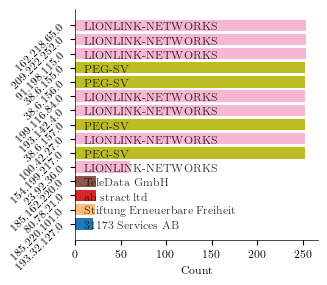

In [22]:
# Get top subnets
top_subnets = all_unique_ips['subnet'].value_counts().head(15)

# Create plot data - only get ASN for top subnets
plot_data = []
for subnet in top_subnets.index:
    count = top_subnets[subnet]
    sample_ip = all_unique_ips[all_unique_ips['subnet'] == subnet]['ip'].iloc[0]
    asn = ip_to_asn(sample_ip)
    plot_data.append({'subnet': subnet, 'count': count, 'asn': asn})

plot_df = pd.DataFrame(plot_data)
plot_df = plot_df.sort_values('count')

# Color mapping and plotting
unique_asns = plot_df['asn'].unique()
cmap = plt.cm.tab20
colors = [cmap(i / len(unique_asns)) for i in range(len(unique_asns))]
asn_color_map = dict(zip(unique_asns, colors))
bar_colors = [asn_color_map[asn] for asn in plot_df['asn']]

fig, ax = plt.subplots(figsize=(3.13, 3))
bars = ax.barh(range(len(plot_df)), plot_df['count'], color=bar_colors)
ax.set_yticks(range(len(plot_df)))
ax.set_yticklabels([subnet.split('/')[0] for subnet in plot_df['subnet']], rotation=45, fontsize=8)

def clean_asn_name(asn):
    return str(asn).replace('&', 'and').replace('_', ' ')

for i, (bar, asn) in enumerate(zip(bars, plot_df['asn'])):
    clean_asn = clean_asn_name(asn)
    ax.text(10, (bar.get_y() + bar.get_height()/2)-0.1,
            f'{clean_asn}', ha='left', va='center', fontsize=8, alpha=0.8)

ax.set_xlabel('Count')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_linewidth(0.5)
ax.spines['bottom'].set_linewidth(0.5)
#plt.tight_layout()
plt.show()

In [23]:
print(top_subnets.keys()[:11])

peer_packets_df['subnet'] = peer_packets_df['source_ip'].apply(lambda ip: str(ipaddress.IPv4Network(f"{ip}/24", strict=False).network_address) + "/24")

anomaly_dict['high_subnet'] = peers_df[peers_df['subnet'].isin(top_subnets.keys()[:11])]['ip'].unique()

anomaly_dict['high_subnet'] = peer_packets_df[peer_packets_df['subnet'].isin(top_subnets.keys()[:11])]['source_ip'].unique()

Index(['209.222.252.0/24', '91.198.115.0/24', '162.218.65.0/24',
       '154.199.217.0/24', '193.142.4.0/24', '100.42.27.0/24', '38.6.157.0/24',
       '38.6.155.0/24', '38.6.156.0/24', '199.116.84.0/24', '23.92.36.0/24'],
      dtype='object', name='subnet')


In [24]:
signature_only_ips = pd.read_csv('results/signature_only_ips.csv', names=['ip'])
anomaly_dict['signature_only'] = signature_only_ips['ip'].unique()

In [25]:
total_anomaly_set = set()
for a in anomaly_dict:
    print(f"{a}: \n     len: {len(anomaly_dict[a])} - ")
    total_anomaly_set.update(anomaly_dict[a])

print(total_anomaly_set)
print(len(total_anomaly_set))
totalSusPeers = None

support_falgs: 
     len: 725 - 
last_seen: 
     len: 62 - 
PL_div: 
     len: 0 - 
short_lived_1_two: 
     len: 78 - 
short_lived_1_ten: 
     len: 11 - 
ping_flooding: 
     len: 502 - 
throttled_ts: 
     len: 174 - 
pl_sim: 
     len: 284 - 
high_subnet: 
     len: 567 - 
signature_only: 
     len: 1725 - 
{'199.116.84.191', '209.97.154.0', '188.245.52.192', '97.102.228.230', '116.203.45.151', '159.69.121.196', '162.218.65.141', '91.198.115.16', '159.69.215.100', '193.142.4.60', '193.142.4.198', '91.198.115.62', '91.198.115.40', '193.142.4.120', '186.190.208.136', '199.116.84.71', '209.222.252.33', '146.190.188.220', '193.142.4.62', '199.116.84.28', '34.162.77.203', '193.142.4.40', '199.116.84.126', '199.116.84.240', '49.12.222.67', '23.88.42.79', '209.97.189.94', '142.93.132.1', '193.142.4.147', '199.116.84.77', '209.222.252.39', '100.42.27.147', '91.198.115.89', '143.198.27.49', '193.142.4.67', '91.107.224.99', '138.197.83.210', '34.162.70.51', '49.13.139.15', '185.231.102.51',

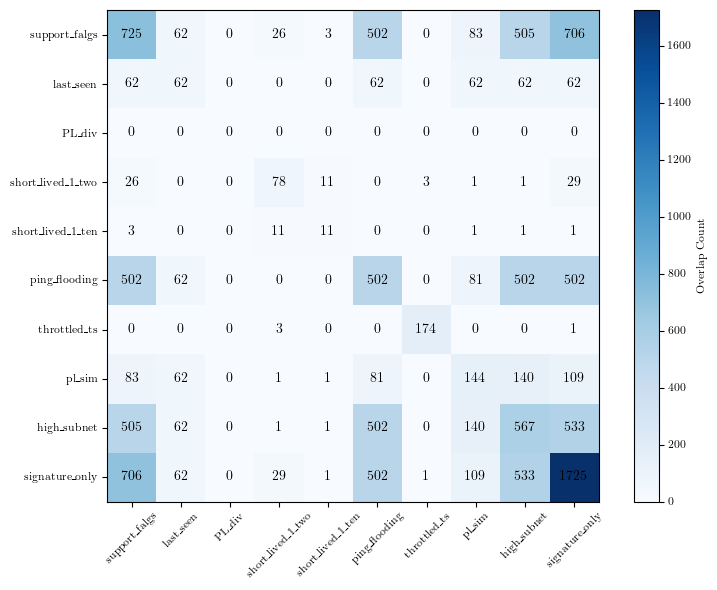

In [26]:
def plot_overlap_matrix(data_dict):
    keys = list(data_dict.keys())
    n = len(keys)
    matrix = np.zeros((n, n))
    
    for i, key1 in enumerate(keys):
        for j, key2 in enumerate(keys):
            overlap = len(set(data_dict[key1]) & set(data_dict[key2]))
            matrix[i, j] = overlap
    
    plt.figure(figsize=(8, 6))
    plt.imshow(matrix, cmap='Blues')
    plt.colorbar(label='Overlap Count')
    plt.xticks(range(n), keys, rotation=45)
    plt.yticks(range(n), keys)
    
    # Add values to cells
    for i in range(n):
        for j in range(n):
            plt.text(j, i, int(matrix[i, j]), ha='center', va='center')
    
    plt.tight_layout()
    plt.show()

plot_overlap_matrix(anomaly_dict)

incoming - Average proportions:
  anomalous: 0.191
  non-anomalous: 0.809
outgoing - Average proportions:
  anomalous: 0.161
  non-anomalous: 0.839


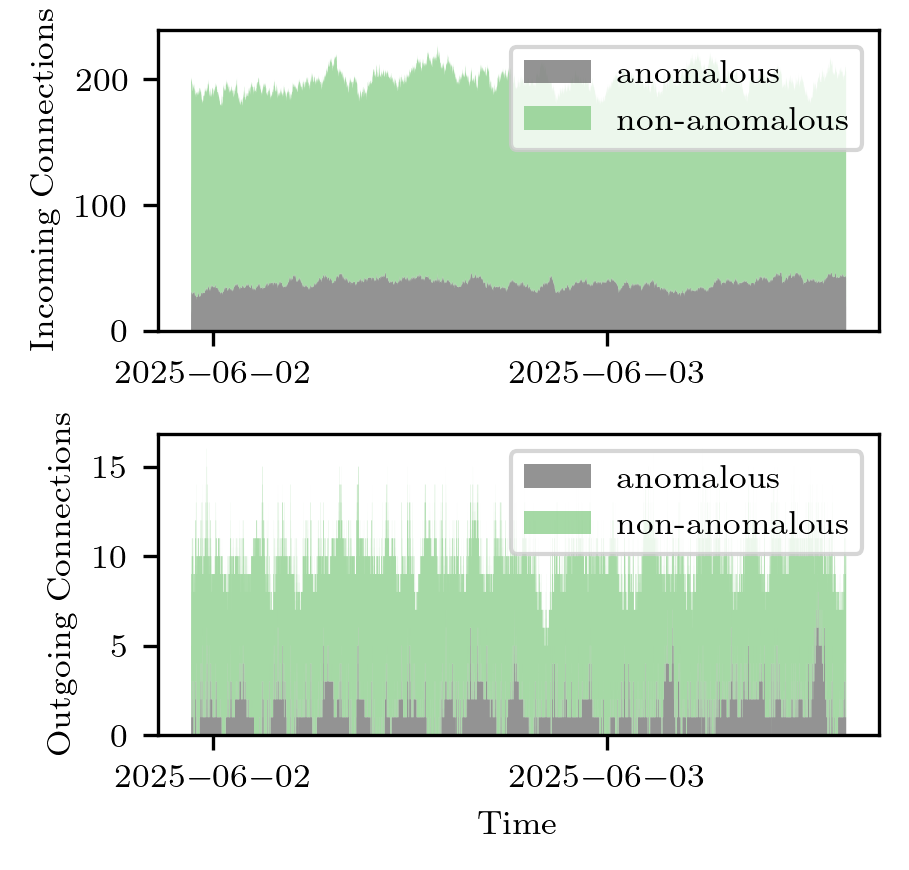

In [27]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

events = []
for idx, row in conn_df.iterrows():
    conn_id = row['connection_id']
    conn = grouped.get_group(conn_id)
    timestamps = conn['timestamp']
    
    start_time = timestamps.iloc[0]
    end_time = timestamps.iloc[-1]
    direction = row['direction']

    duration_m = row['duration']

    if row['peer_ip'] in total_anomaly_set:
        conn_type = 'anomalous'
    else:
        conn_type = 'non-anomalous'
    
    events.append({'time': start_time, 'direction': direction, 'classification': conn_type, 'change': 1})
    events.append({'time': end_time, 'direction': direction, 'classification': conn_type, 'change': -1})


events_df = pd.DataFrame(events)
events_df = events_df.sort_values('time').set_index('time')

classifications = events_df['classification'].unique()
colors = plt.cm.Accent(np.linspace(0, 1, len(classifications)))
color_map = dict(zip(classifications, colors))

# Plot for each direction
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(3.13, 3), dpi=300)

for direction, ax, title in [('incoming', ax1, 'Incoming'), ('outgoing', ax2, 'Outgoing')]:
    direction_events = events_df[events_df['direction'] == direction]
    
    # Create pivot table and resample
    pivot = direction_events.pivot_table(
        index='time', 
        columns='classification', 
        values='change', 
        aggfunc='sum', 
        fill_value=0
    )
    
    # Resample to regular intervals and forward fill
    resampled = pivot.resample('1s').sum().fillna(0)
    cumulative = resampled.cumsum()
    
    # Ensure no negative values
    cumulative = cumulative.clip(lower=0)
    
    # Create stacked area plot              
    if not cumulative.empty:
        ax.stackplot(cumulative.index, 
                    *[cumulative[cls] for cls in cumulative.columns],
                    labels=cumulative.columns,
                    colors=[color_map[cls] for cls in cumulative.columns],
                    alpha=0.7)
    
    #ax.set_title(f'{title} Connections Over Time')
    ax.set_ylabel(f'{title} Connections')
    ax.legend(loc='upper right')
    ax.xaxis.set_major_locator(plt.MaxNLocator(nbins=2))

    # calcproportion
    cumulative = resampled.cumsum().clip(lower=0)
    
    # Calculate proportions
    total_active = cumulative.sum(axis=1)
    # Only consider time points where connections exist
    mask = total_active > 0
    proportions = cumulative[mask].div(total_active[mask], axis=0)
    average_proportions = proportions.mean()
    
    print(f"{direction} - Average proportions:")
    for conn_type, prop in average_proportions.items():
        print(f"  {conn_type}: {prop:.3f}")

ax2.set_xlabel('Time')
plt.tight_layout()
plt.savefig('results/wo-banlist/conn_saturation.pdf')
plt.show()


In [30]:
#print(total_anomaly_set)
tmp_asns = set()
for ip in total_anomaly_set:
    tmp_asns.add(ip_to_asn(ip))
#print(tmp_asns)

for an in anomaly_dict:
    tmp_asns = set()
    for ip in anomaly_dict[an]:
        tmp_asns.add(ip_to_asn(ip))
    if len(tmp_asns) < 10:
        print(f"{an}: Unique IPs: {len(anomaly_dict[an])}")
        print(f"    ASNs: {tmp_asns}")
    else:
        print(f"{an}: Unique IPs: {len(anomaly_dict[an])}")
        print(f"    ASNs: {len(tmp_asns)}")
    print()

support_falgs: Unique IPs: 725
    ASNs: 20

last_seen: Unique IPs: 62
    ASNs: {'LIONLINK-NETWORKS'}

PL_div: Unique IPs: 0
    ASNs: set()

short_lived_1_two: Unique IPs: 78
    ASNs: 39

short_lived_1_ten: Unique IPs: 11
    ASNs: {'OVH SAS', 'M247 Europe SRL', 'TZULO', 'NL-811-40021', 'AS-COLOCROSSING', 'CRUNCHBITS', 'LIONLINK-NETWORKS', 'Hetzner Online GmbH'}

ping_flooding: Unique IPs: 502
    ASNs: {'LIONLINK-NETWORKS'}

throttled_ts: Unique IPs: 174
    ASNs: 85

pl_sim: Unique IPs: 284
    ASNs: {'CHINA UNICOM China169 Backbone', 'AMAZON-02', 'DIGITALOCEAN-ASN', 'LIONLINK-NETWORKS', 'Digi Spain Telecom S.l.'}

high_subnet: Unique IPs: 2593
    ASNs: {'LIONLINK-NETWORKS', 'PEG-SV'}

signature_only: Unique IPs: 1725
    ASNs: {'GOOGLE-CLOUD-PLATFORM', 'Tele2 SWIPnet', 'CETIN Bulgaria EAD', 'DIGITALOCEAN-ASN', 'LIONLINK-NETWORKS', 'Hetzner Online GmbH'}



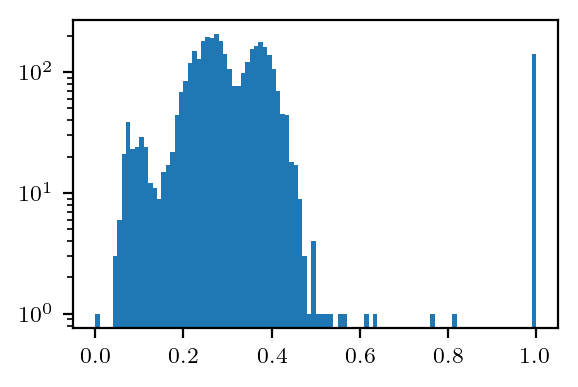

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
0.32172717950252794
0.29258738924204697


In [29]:
anomaly_dict['high_subnet'] = peers_df[peers_df['subnet'].isin(top_subnets.keys()[:11])]['ip'].unique()
total_anomaly_set = set()
for a in anomaly_dict:
    #print(f"{a}: \n     len: {len(anomaly_dict[a])} - ")
    total_anomaly_set.update(anomaly_dict[a])

overlaps = []
portions = []

for _, row in pl_by_source_ip.iterrows():
    overlap = len(set(row['peer_ips']) & set(total_anomaly_set))
    promotions = len(set(row['peer_ips']))

    portion = overlap/promotions

    portions.append(portion)


plt.figure(figsize=(3.13,2), dpi=200)
plt.hist(portions, range=(0,1), bins=100, log=True)
plt.show()
print(sorted(portions)[-10:-1])
print(np.mean(portions))

print(np.median(sorted(portions)))